In [1]:
import arviz as az
import bambi as bmb
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from causalgraphicalmodels import CausalGraphicalModel
from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
az.style.use("arviz-darkgrid")
np.random.seed(1211)

#### Code 5.1

We first need to define the function that is going to standardize numeric variables.

In [3]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [4]:
d = pd.read_csv("data/WaffleDivorce.csv")
d["D"] = standardize(d["Divorce"])
d["M"] = standardize(d["Marriage"])
d["A"] = standardize(d["MedianAgeMarriage"])

#### Code 5.2

In [5]:
np.std(d["MedianAgeMarriage"])

1.231131187160816

#### Coce 5.3

In [6]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_1 = bmb.Model("D ~ A", d, priors=priors)
results_5_1 = model_5_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, Intercept]


#### Code 5.4

We call `.prior_predictive()` on the model object and take the prior samples from the InferenceData object returned.

In [7]:
prior_predictive = model_5_1.prior_predictive().prior
a = prior_predictive["Intercept"].values.flatten()
bA = prior_predictive["A"].values.flatten()

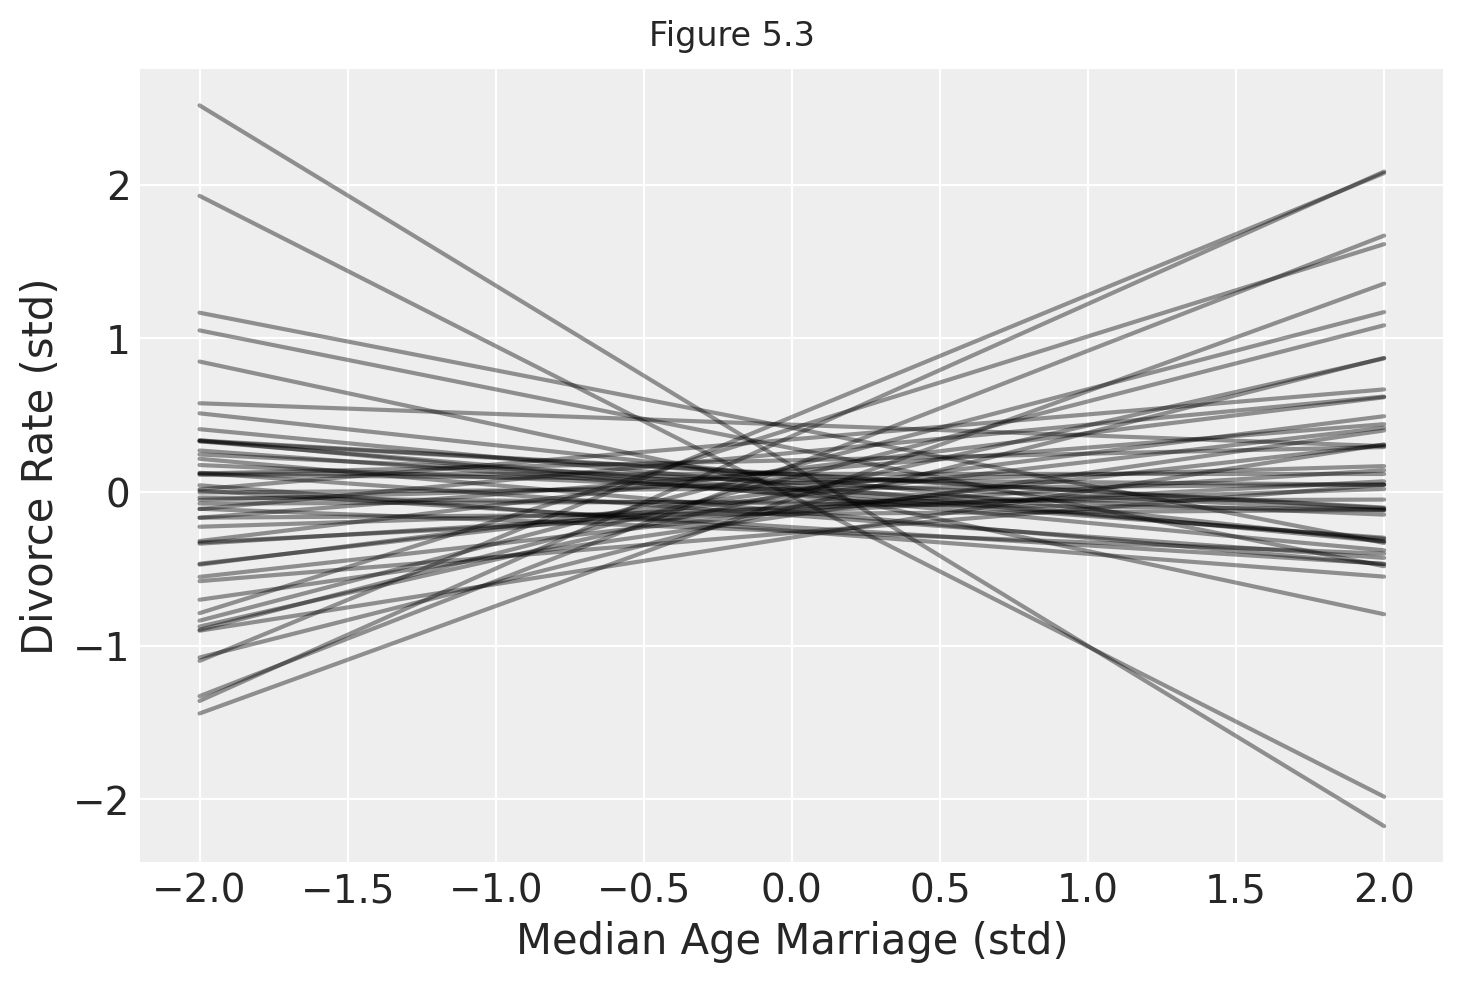

In [8]:

fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(a[:50], bA[:50]):
    ax.plot(x, a + ba * x, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

In [9]:
A_seq = np.linspace(-3, 3.2, 30)
a = results_5_1.posterior["Intercept"].values.flatten()
bA = results_5_1.posterior["A"].values.flatten()
mu_pred = np.zeros((len(A_seq), len(a)))

for i, age in enumerate(A_seq):
    mu_pred[i] = a + bA * age

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

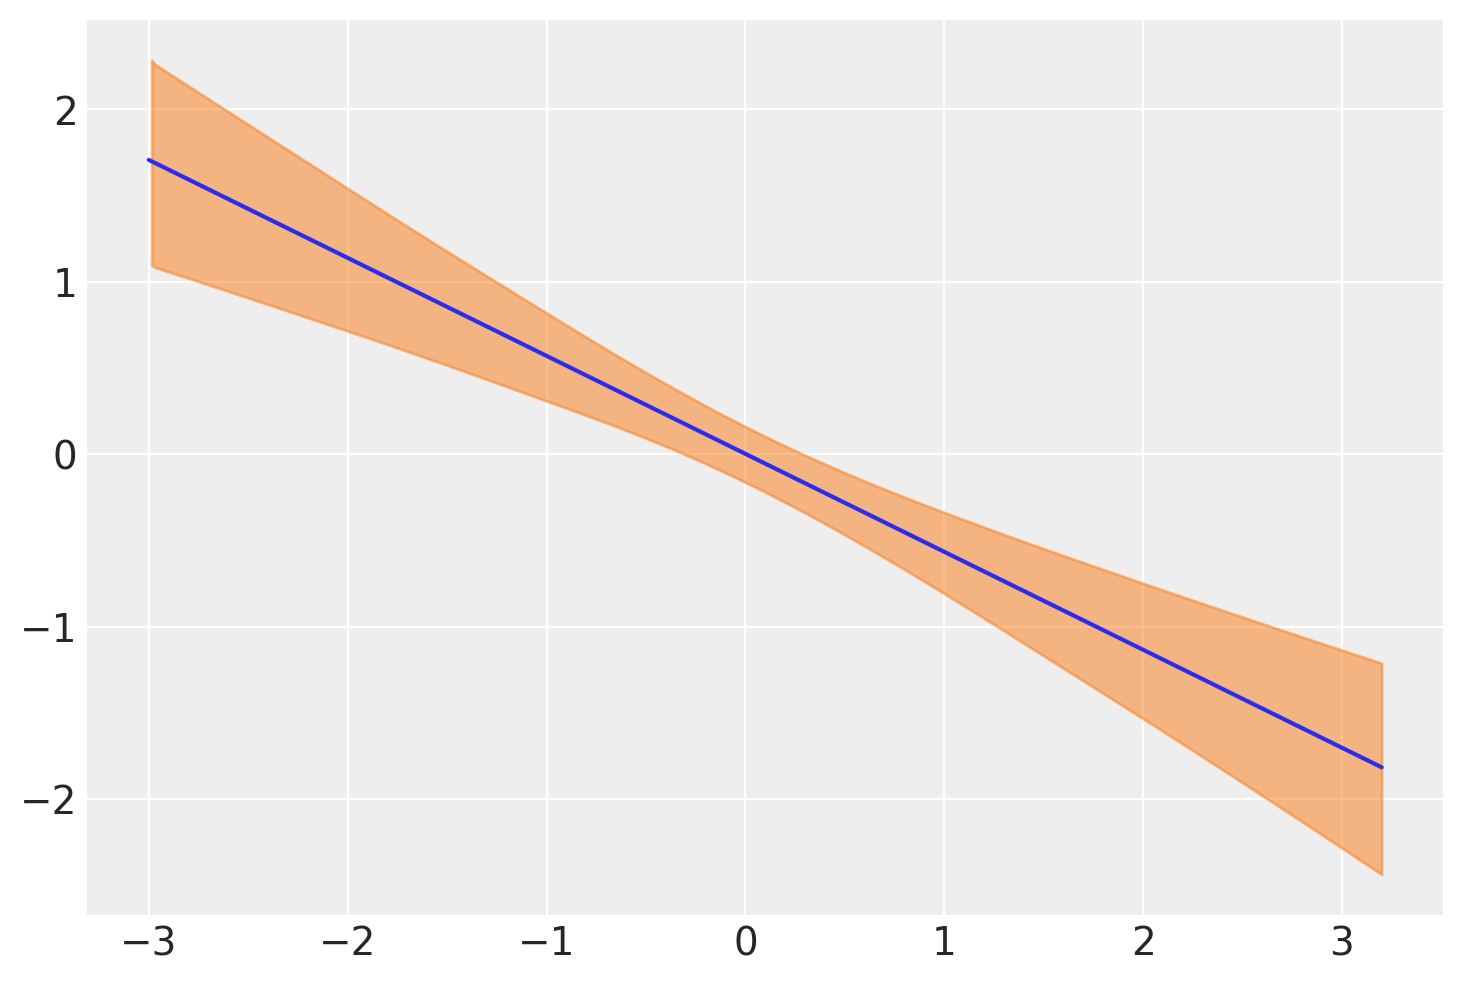

In [10]:
az.plot_hdi(A_seq, hdi_data=mu_PI)
plt.plot(A_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

In the previous call to `az.plot_hdi()` we have passed the `mu_PI` array we've manually computed to mimic the original code in the book. However, we could have just used `az.plot_hdi(A_seq, mu_pred.T)` and ArviZ would compute the interval for us.

#### Code 5.6

In [11]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "M": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_2 = bmb.Model("D ~ M", d, priors=priors)
results_5_2 = model_5_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, M, Intercept]


#### Code 5.7

Add something here such as credits to original author

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


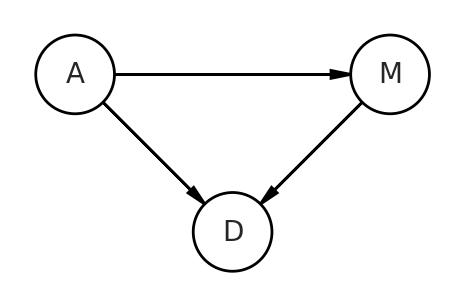

In [12]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

#### Code 5.8

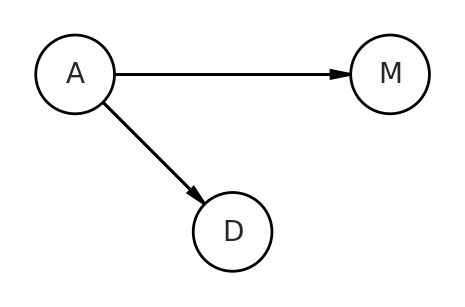

In [13]:
dag5_2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [14]:
print(dag5_2.get_distribution())


P(A)P(M|A)P(D|A)


In [15]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [16]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


#### Code 5.9

There are no conditional independencies, so there is no output to display.

In [17]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

#### Code 5.10

In [18]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "M": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_3 = bmb.Model("D ~ M + A", d, priors=priors)
results_5_3 = model_5_3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, M, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [19]:
az.summary(results_5_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.001,0.101,-0.189,0.188
M,-0.061,0.164,-0.370,0.236
A,-0.611,0.160,-0.902,-0.313
D_sigma,0.838,0.088,0.678,0.998


#### Code 5.11

There's so much space in the plot, see if it is possible to reduce it.

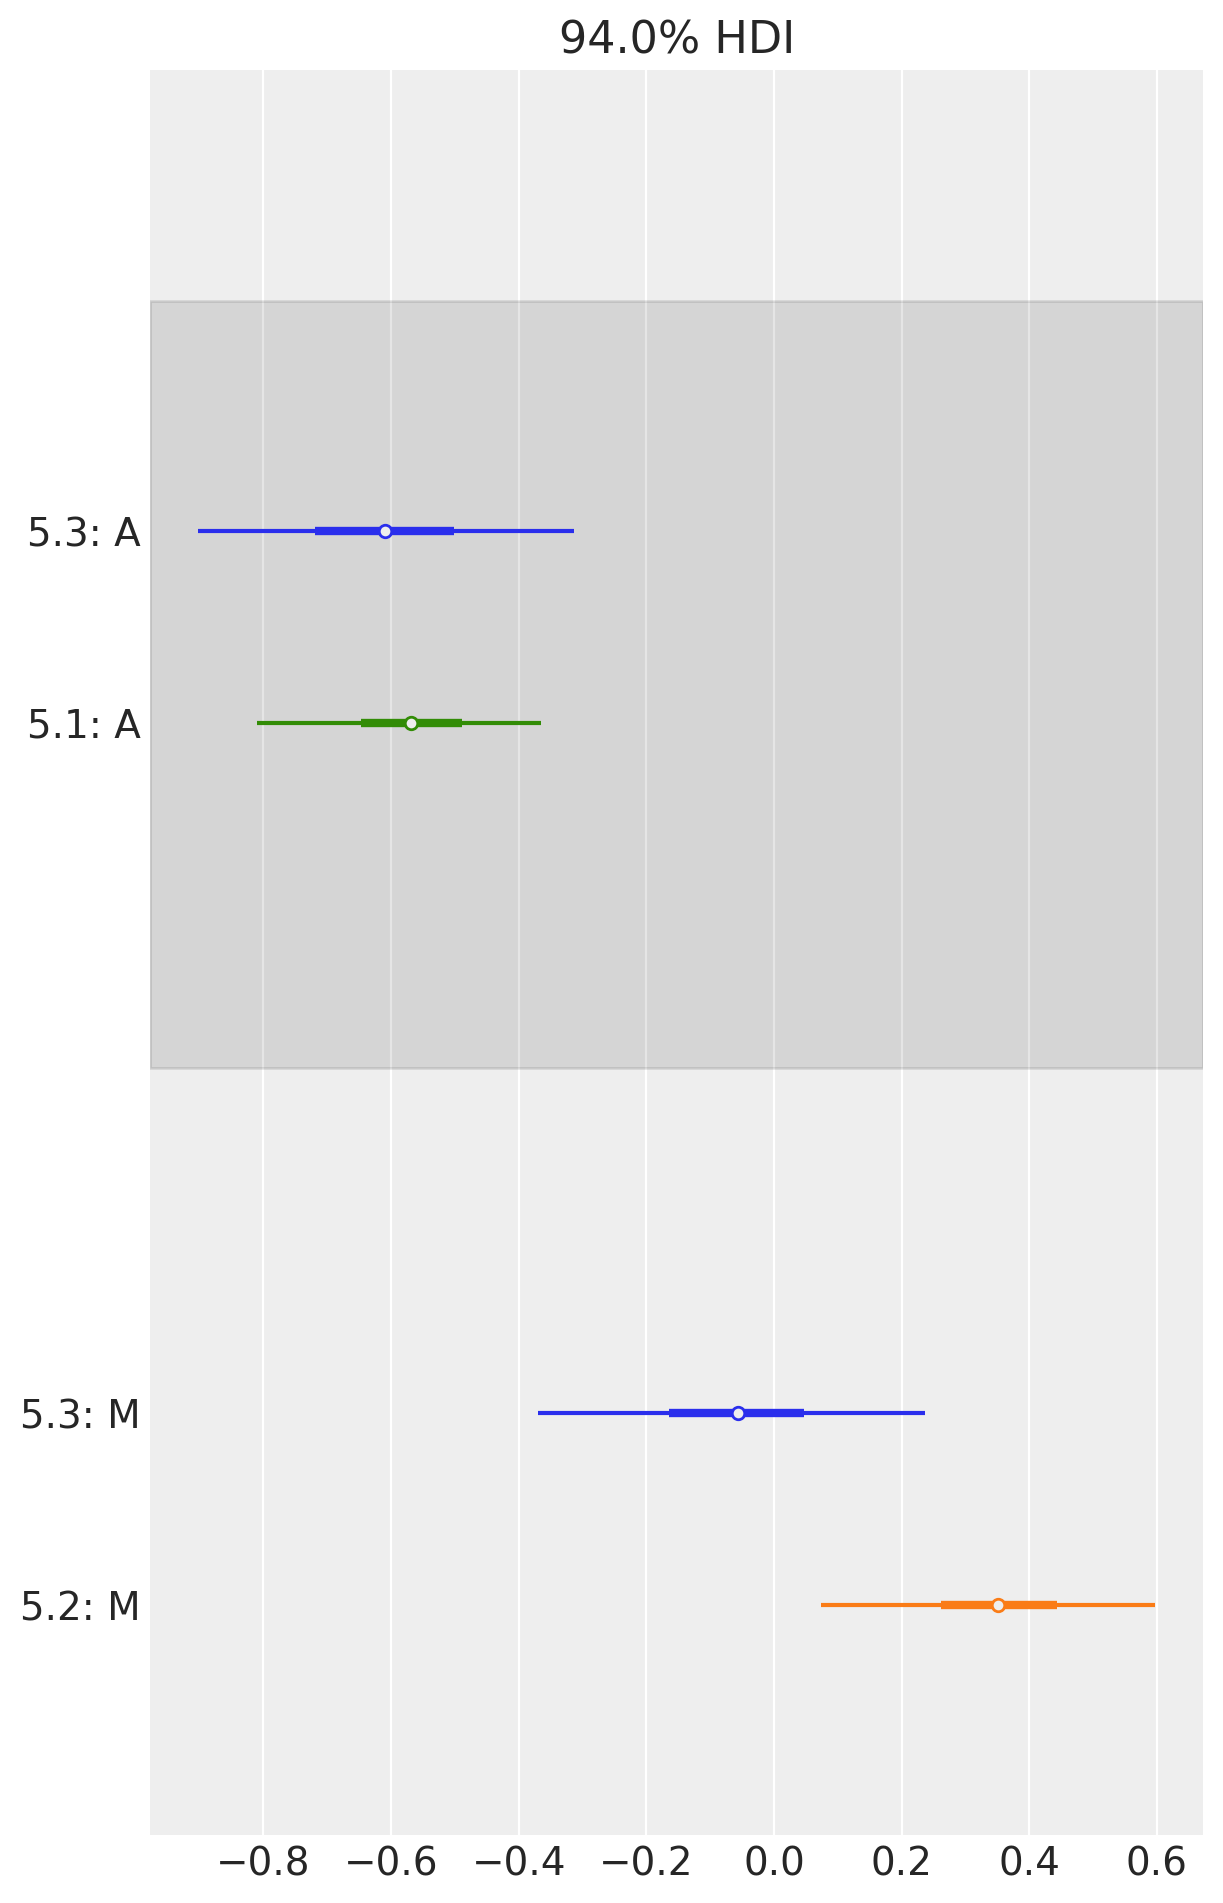

In [20]:
az.plot_forest(
    [
        results_5_3,
        results_5_2,
        results_5_1,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["A", "M"],
    combined=True,
);

#### Code 5.12

In [21]:
N = 50
age = stats.norm().rvs(N)     # sim A
mar = stats.norm(-age).rvs(N) # sim A -> M
div = stats.norm(age).rvs(N)  # sim A -> D

#### Code 5.13

Note we use one predictor to predict the other. In this first model we use `A` to predict `M`.

In [22]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_4 = bmb.Model("M ~ A", d, priors=priors)
results_5_4 = model_5_4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [M_sigma, A, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


#### Code 5.14

Here we use the observed values of `A` to predict the values of `M`. Then we subtract this prediction (the mean) from the observed values of `M` and we get the residuals. These residuals are the segments in the top left panel in Figure 5.4 in the book.

In [23]:
A_seq = d["A"]
a = results_5_4.posterior["Intercept"].values.flatten()
bA = results_5_4.posterior["A"].values.flatten()
mu_pred = np.zeros((len(A_seq), len(a)))

for i, age in enumerate(A_seq):
    mu_pred[i] = a + bA * age

mu_mean = mu_pred.mean(1)
mu_resid = d["M"] - mu_mean

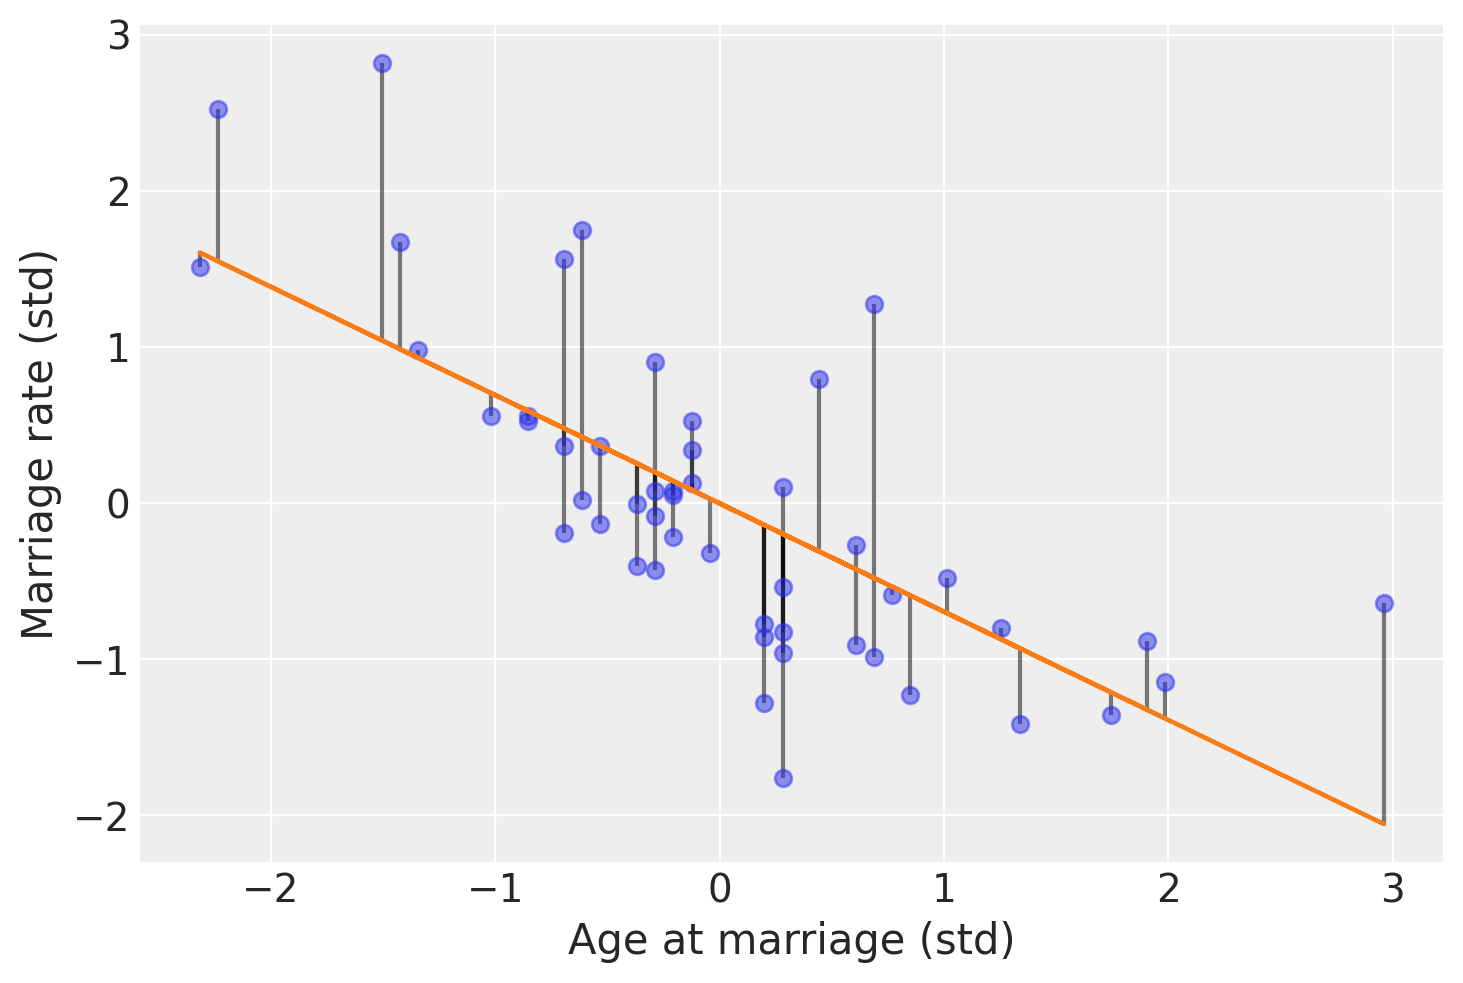

In [24]:
plt.plot(d["A"], d["M"], "o", alpha=0.5)
plt.vlines(d["A"], ymin=mu_mean, ymax=d["M"], color="black", alpha=0.5)
plt.plot(d["A"], mu_mean)
plt.xlabel("Age at marriage (std)")
plt.ylabel("Marriage rate (std)");

#### Code 5.15

In [25]:
model_5_3

Formula: D ~ M + A
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(mu: 0, sd: 0.2)
  M ~ Normal(mu: 0, sd: 0.5)
  A ~ Normal(mu: 0, sd: 0.5)
  sigma ~ Exponential(lam: 1)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [26]:
a = results_5_3.posterior["Intercept"].values.flatten()
bM = results_5_3.posterior["M"].values.flatten()
bA = results_5_3.posterior["A"].values.flatten()
mu_pred = np.zeros((d.shape[0], len(a))) # data.shape[0] equals number of observations

for i in range(d.shape[0]):
    mu_pred[i] = a + bM * d["M"][i] + bA * d["A"][i]

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

In [27]:
# Here we use the original data
model_5_3.posterior_predictive(results_5_3, 1000)

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [28]:
D_sim = results_5_3.posterior_predictive["D"].mean(axis=0).values
D_PI = np.quantile(D_sim, [0.05, 0.94], axis=1).T

#### Code 5.16

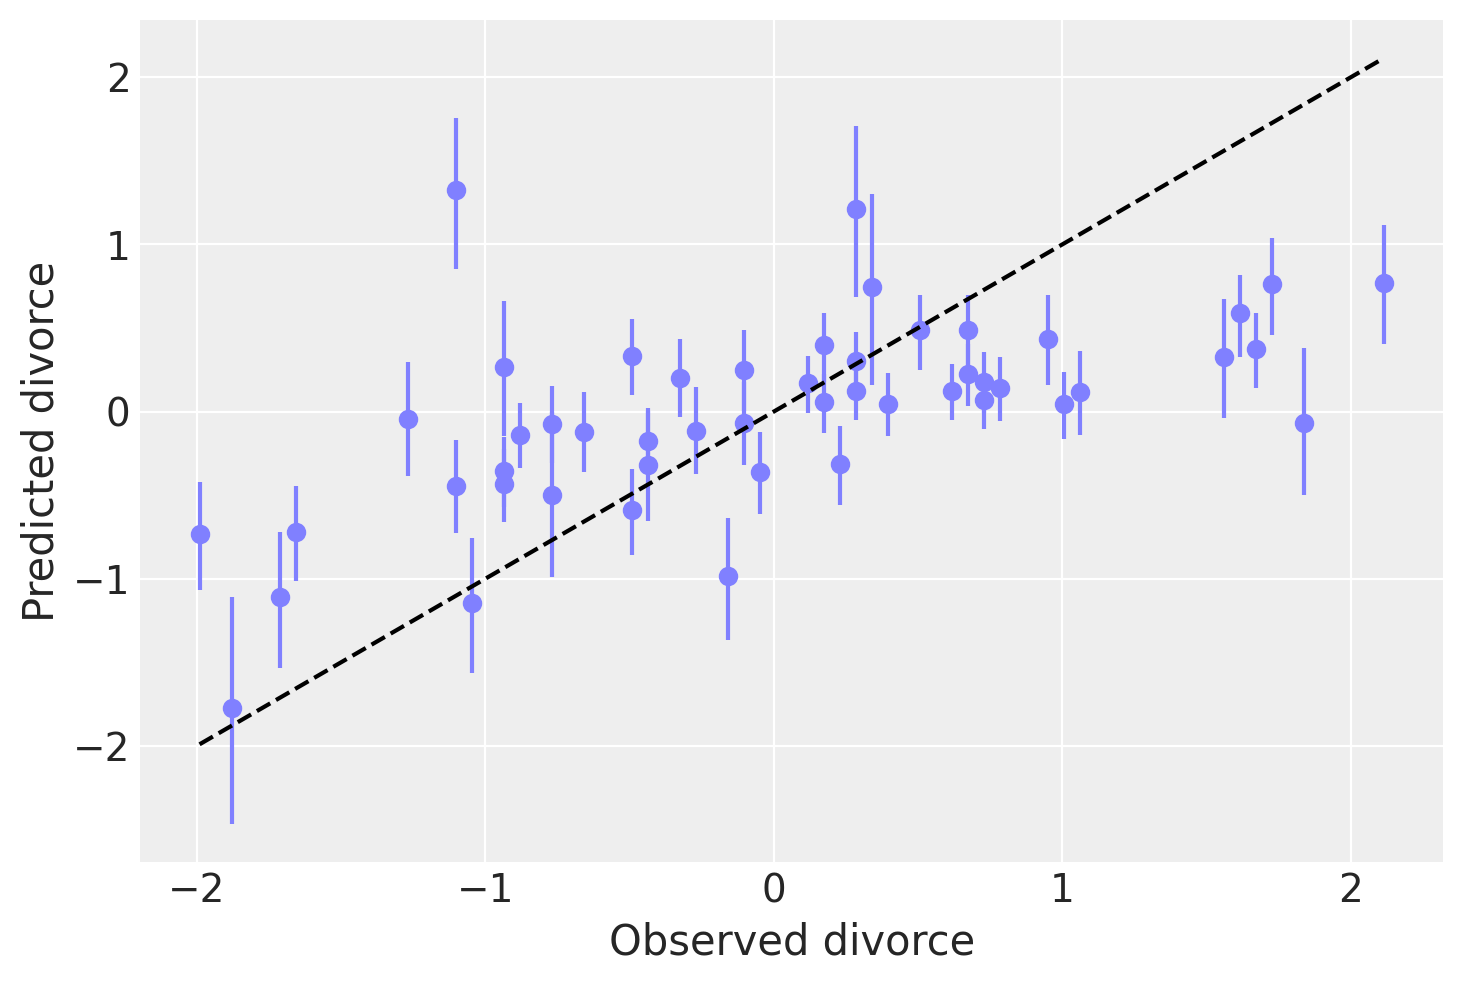

In [29]:
plt.plot(d["D"], mu_mean, "o", c="#8080FF")
# Line with intercept 0 and slope 1
x = [d["D"].min(), d["D"].max()]
plt.plot(x, x, "k--")
plt.vlines(d["D"], ymin=mu_PI[:,0], ymax=mu_PI[:,1], color="#8080FF")
plt.xlabel("Observed divorce")
plt.ylabel("Predicted divorce");

#### Code 5.17

We don't do that here since it is not that easy.

#### Code 5.18

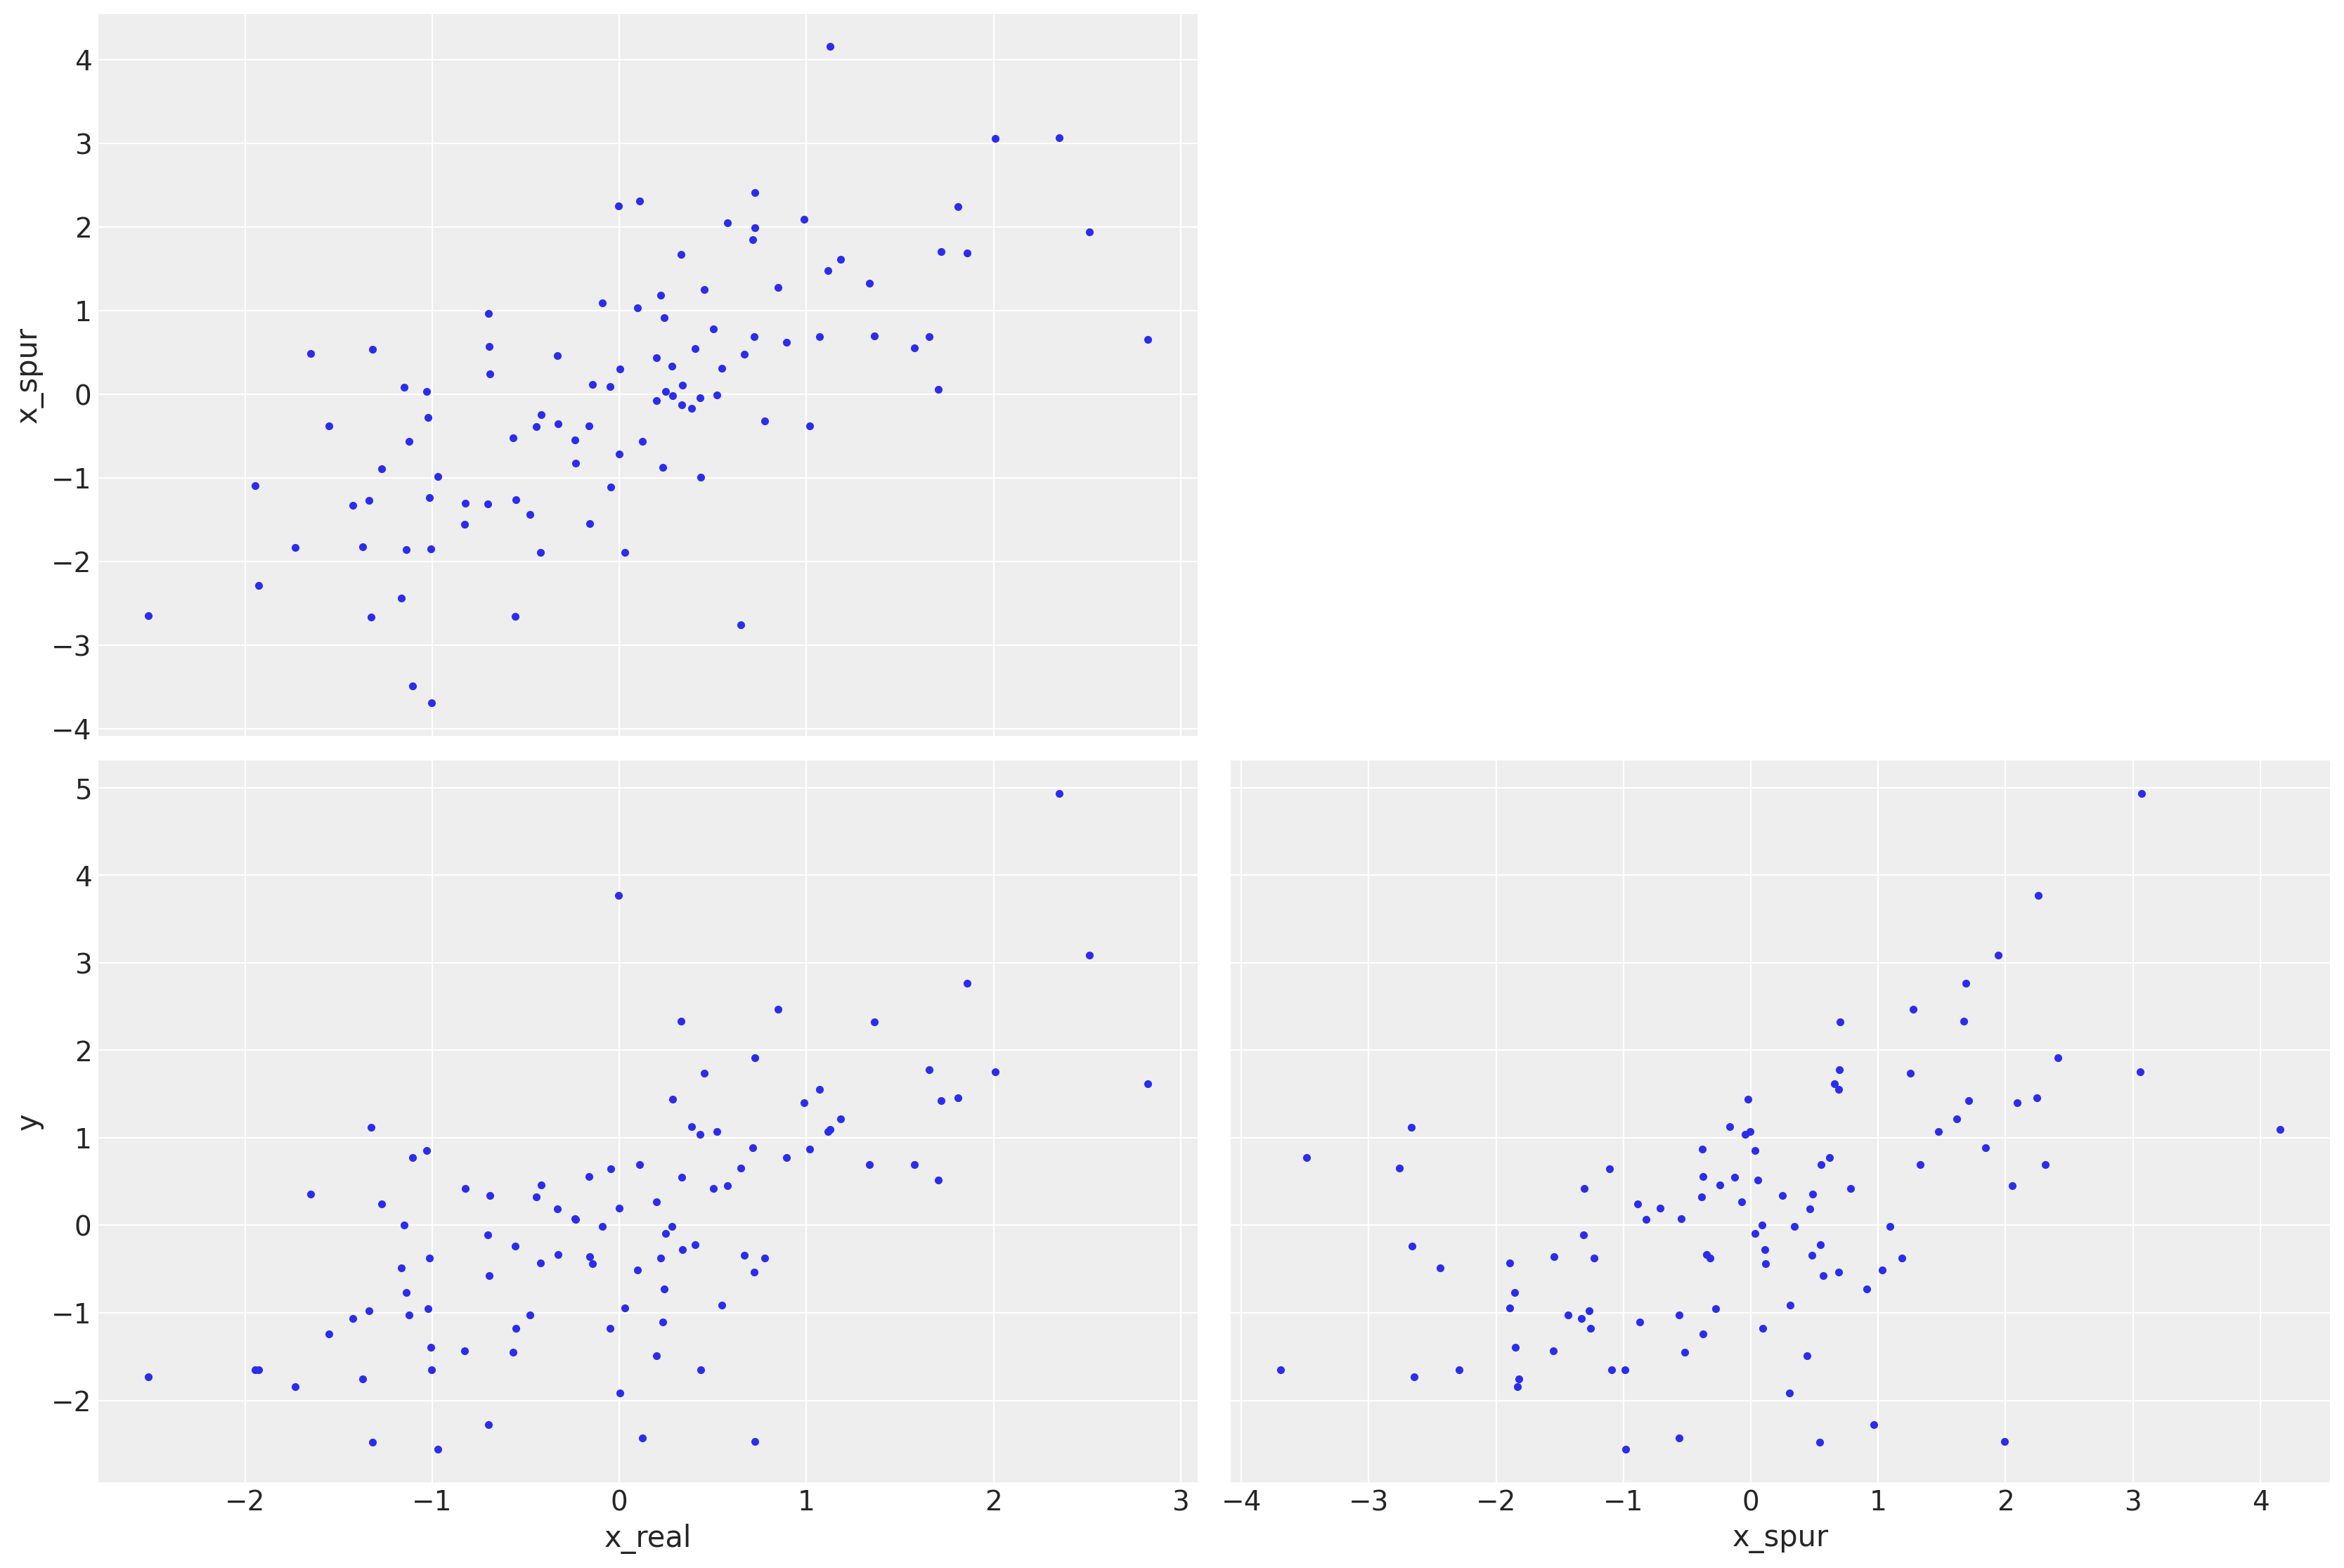

In [30]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### Code 5.19
This is a multivariate regression model, which is not supported in Bambi yet.

#### Code 5.20

#### Code 5.21

#### Code 5.22

#### Code 5.23

#### Code 5.24

#### Code 5.25

#### Code 5.26

#### Code 5.27

#### Code 5.28

In [31]:
d = pd.read_csv("data/milk.csv")
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


#### Code 5.29

In [32]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(np.log(d["mass"]))

#### Code 5.30

In [33]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=1),
    "N": bmb.Prior("Normal", mu=0, sd=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model_5_5_draft = bmb.Model("K ~ N", d, priors=priors)
results_5_5_draft = model_5_5_draft.fit()

ValueError: 'data' contains 12 incomplete rows.

#### Code 5.31

In [34]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### Code 5.32

In [35]:
dcc = d.dropna(subset=["K", "N", "M"])

#### Code 5.33

In [36]:
# Priors are already defined, we show them again for easier recall
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=1),
    "N": bmb.Prior("Normal", mu=0, sd=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model_5_5_draft = bmb.Model("K ~ N", dcc, priors=priors)
results_5_5_draft = model_5_5_draft.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, N, Intercept]


In Bambi, we could pass the argument `dropna=True` to drop any observation containing missing values in the variables involved in the model, so we could just have done `bmb.Model("K ~ N", d, priors=priors, dropna=True)`.

#### Code 5.34

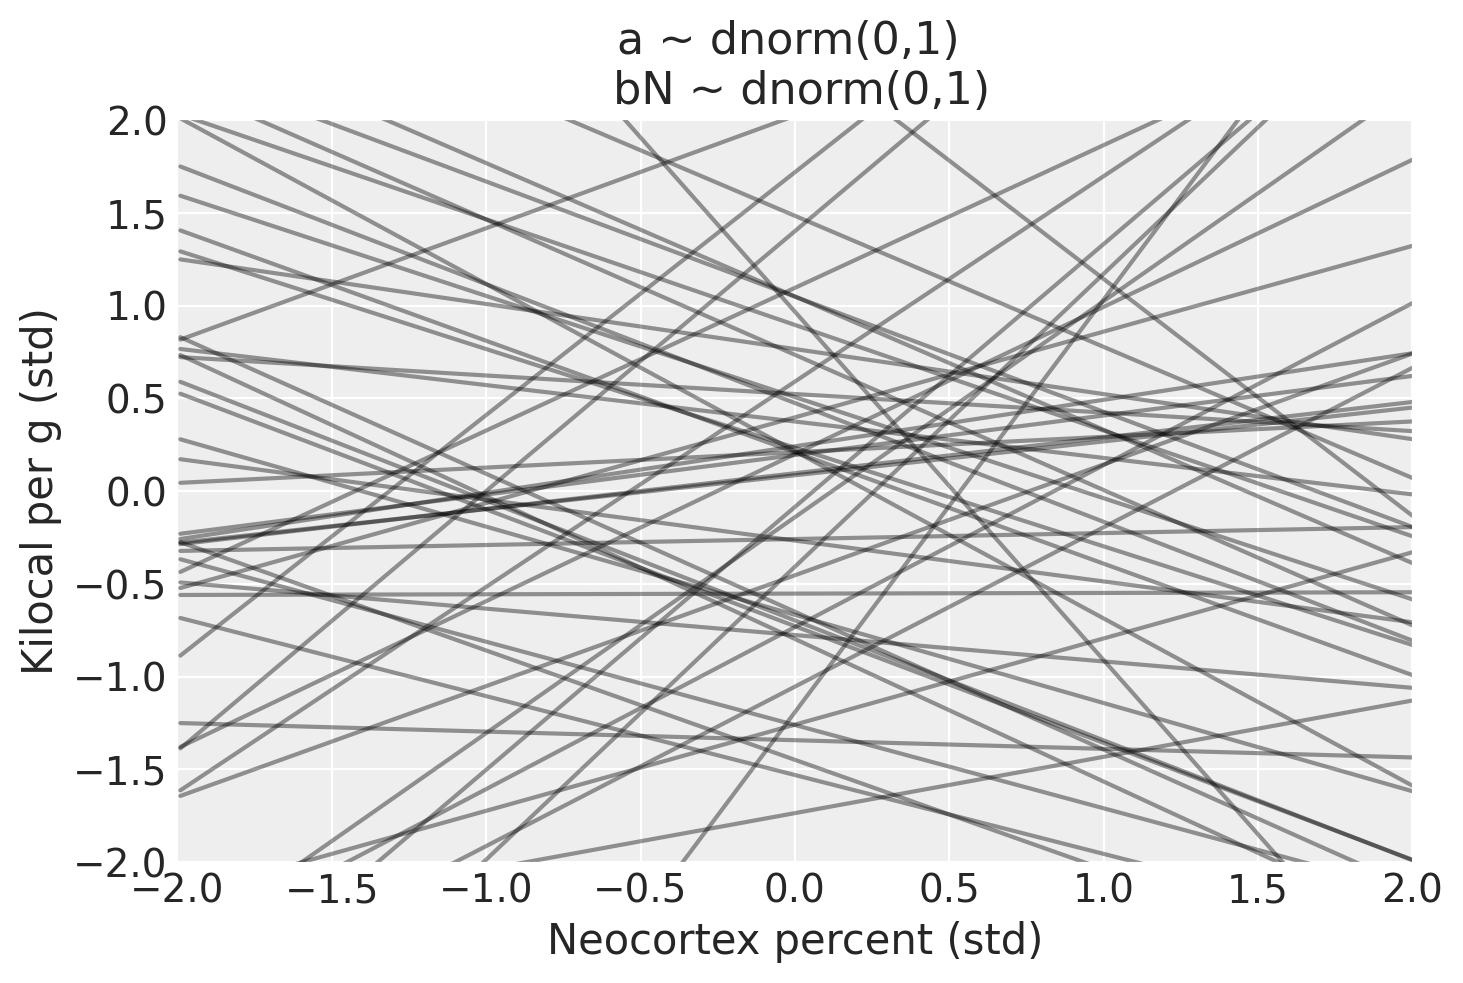

In [37]:
prior_predictive = model_5_5_draft.prior_predictive().prior
a = prior_predictive["Intercept"].values.flatten()
bN = prior_predictive["N"].values.flatten()

fig, ax = plt.subplots()

xseq = np.array([-2, 2])

for a, bn in zip(a[:50], bN[:50]):
    ax.plot(x, a + bn * xseq, c="black", alpha=0.4)

ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_xlabel("Neocortex percent (std)")
ax.set_ylabel("Kilocal per g (std)")
ax.set_title("a ~ dnorm(0,1) \n bN ~ dnorm(0,1)");

#### Code 5.35

In [38]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "N": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model_5_5 = bmb.Model("K ~ N", dcc, priors=priors)
results_5_5 = model_5_5.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, N, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


We can also generate the plot we constructed in Code 5.34 to visualize the effect of the new priors, as you can do on the right panel of Figure 5.8 in the book.

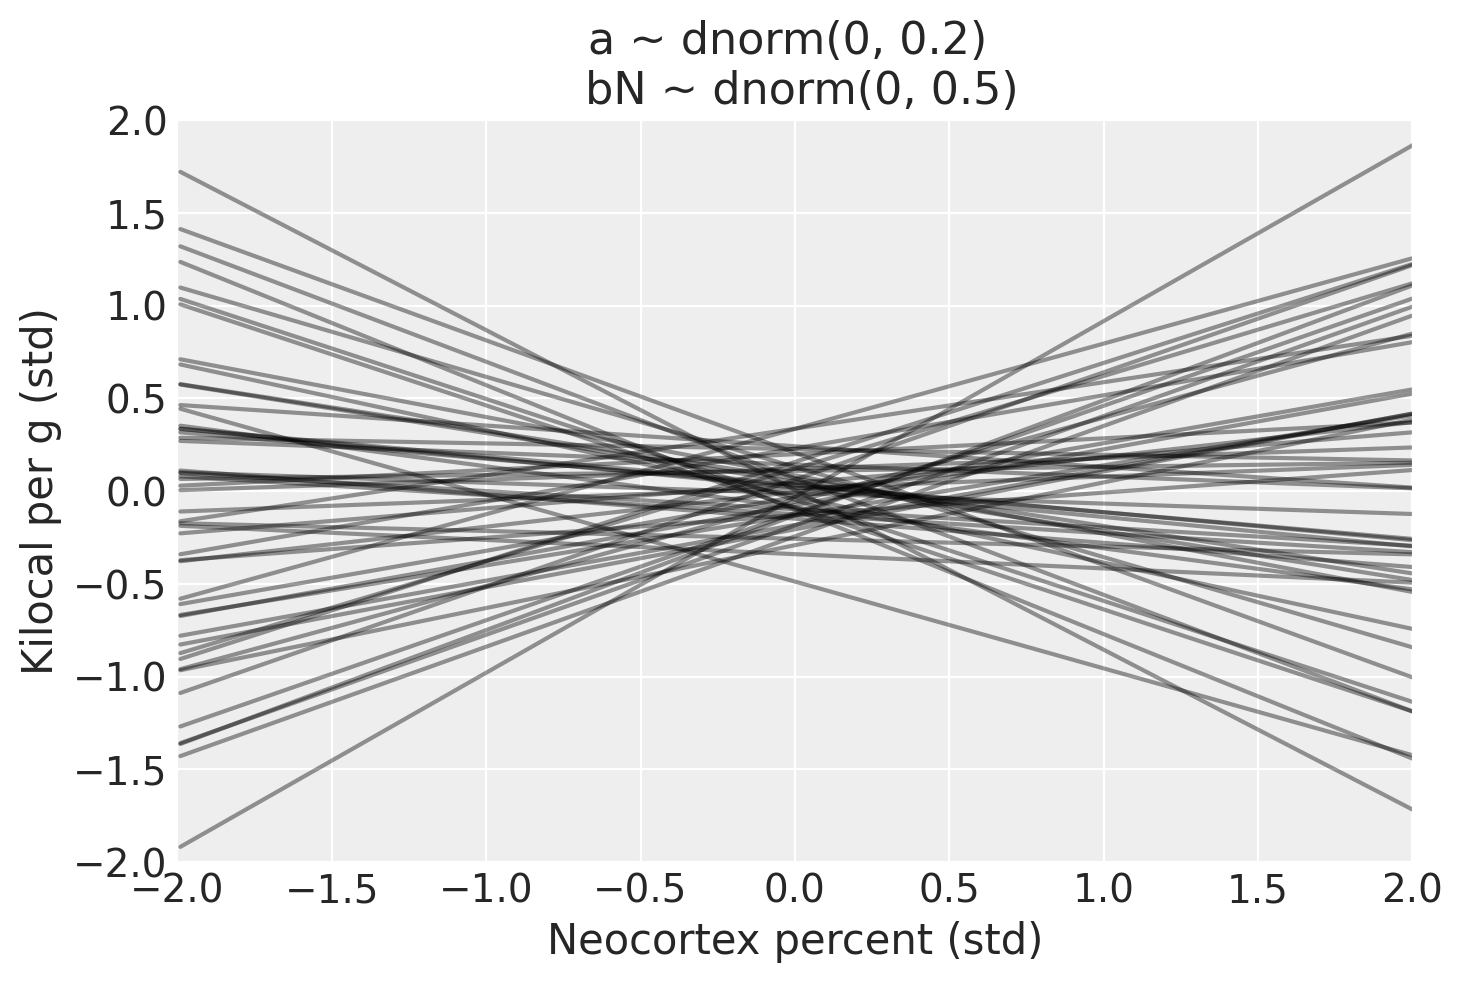

In [39]:
prior_predictive = model_5_5.prior_predictive().prior
a = prior_predictive["Intercept"].values.flatten()
bN = prior_predictive["N"].values.flatten()

fig, ax = plt.subplots()

xseq = np.array([-2, 2])

for a, bn in zip(a[:50], bN[:50]):
    ax.plot(x, a + bn * xseq, c="black", alpha=0.4)

ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_xlabel("Neocortex percent (std)")
ax.set_ylabel("Kilocal per g (std)")
ax.set_title("a ~ dnorm(0, 0.2) \n bN ~ dnorm(0, 0.5)");

#### Code 5.36

In [40]:
az.summary(results_5_5, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.035,0.159,-0.277,0.306
N,0.133,0.249,-0.300,0.632
K_sigma,1.130,0.219,0.782,1.545


#### Code 5.37


In [41]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

a = results_5_5.posterior["Intercept"].values.flatten()
bN = results_5_5.posterior["N"].values.flatten()
mu_pred = np.zeros((len(xseq), len(a)))

for (i, x) in enumerate(xseq):
    mu_pred[i] = a + bN * x

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

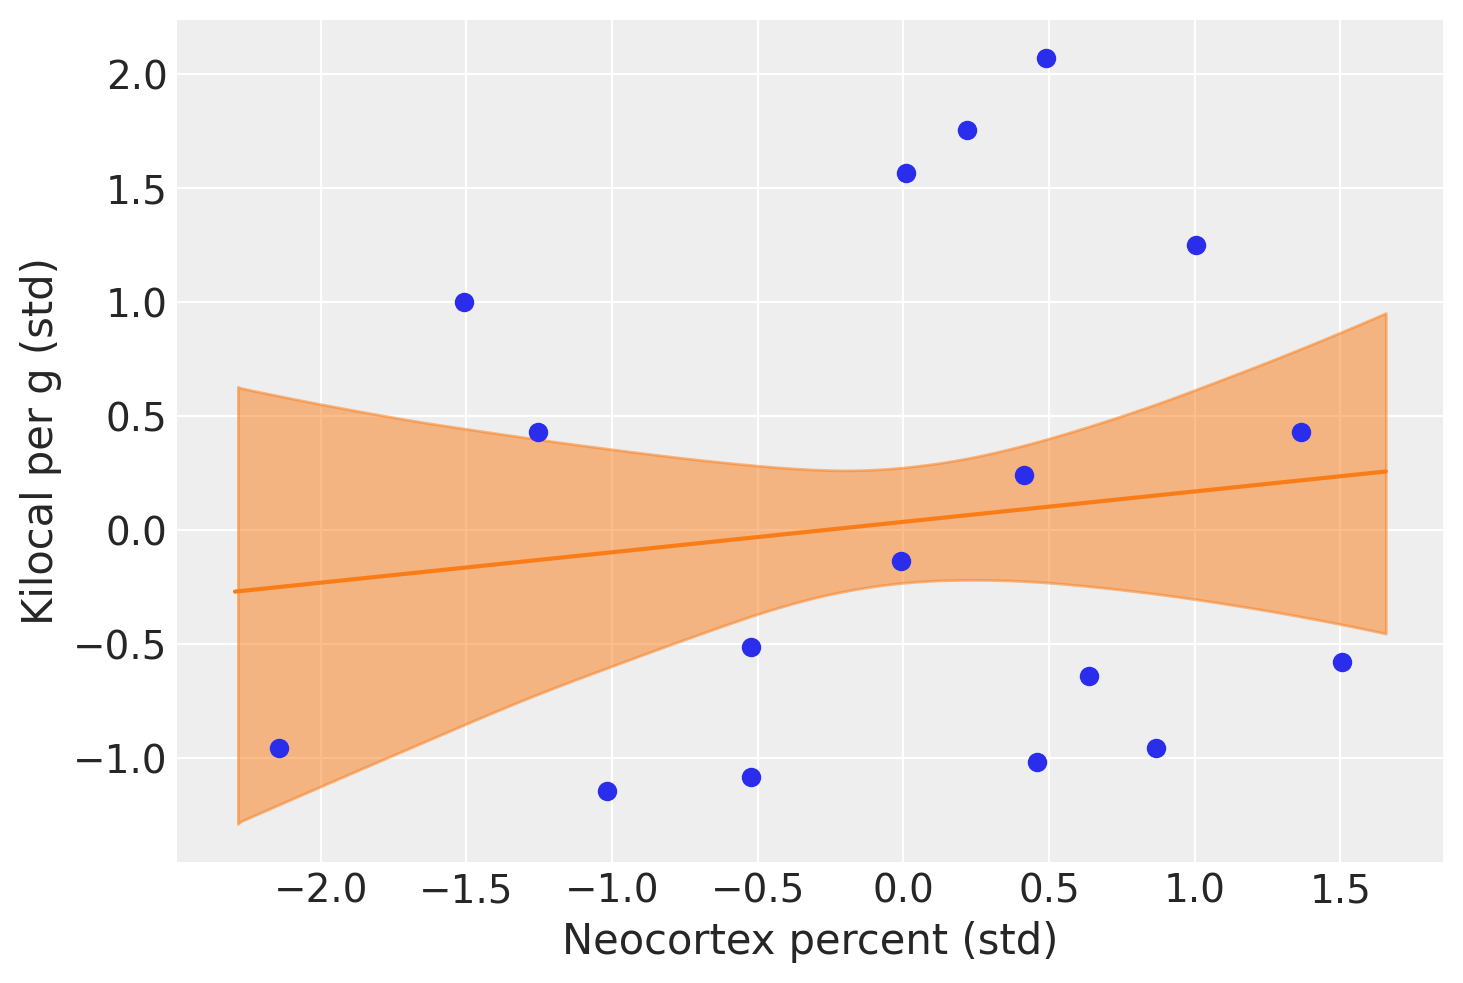

In [42]:
plt.plot(d["N"], d["K"], "o")
plt.plot(xseq, mu_mean)
az.plot_hdi(xseq, hdi_data=mu_PI)
plt.xlabel("Neocortex percent (std)")
plt.ylabel("Kilocal per g (std)");

#### Code 5.38


In [43]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "M": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model_5_6 = bmb.Model("K ~ M", dcc, priors=priors)
results_5_6 = model_5_6.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, M, Intercept]


In [44]:
az.summary(results_5_6, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.041,0.159,-0.253,0.345
M,-0.279,0.213,-0.675,0.117
K_sigma,1.070,0.183,0.756,1.410


One could replicate the top-right panel of Figure 5.9 by reutilizing the code from Code 5.37

#### Code 5.39

In [45]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2),
    "N": bmb.Prior("Normal", mu=0, sd=0.5),
    "M": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model_5_7 = bmb.Model("K ~ N + M", dcc, priors=priors)
results_5_7 = model_5_7.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, M, N, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8824079720304813, but should be close to 0.8. Try to increase the number of tuning steps.


In [46]:
az.summary(results_5_7, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.058,0.148,-0.218,0.326
N,0.576,0.275,0.053,1.072
M,-0.620,0.256,-1.105,-0.166
K_sigma,0.894,0.188,0.613,1.267


#### Code 5.40

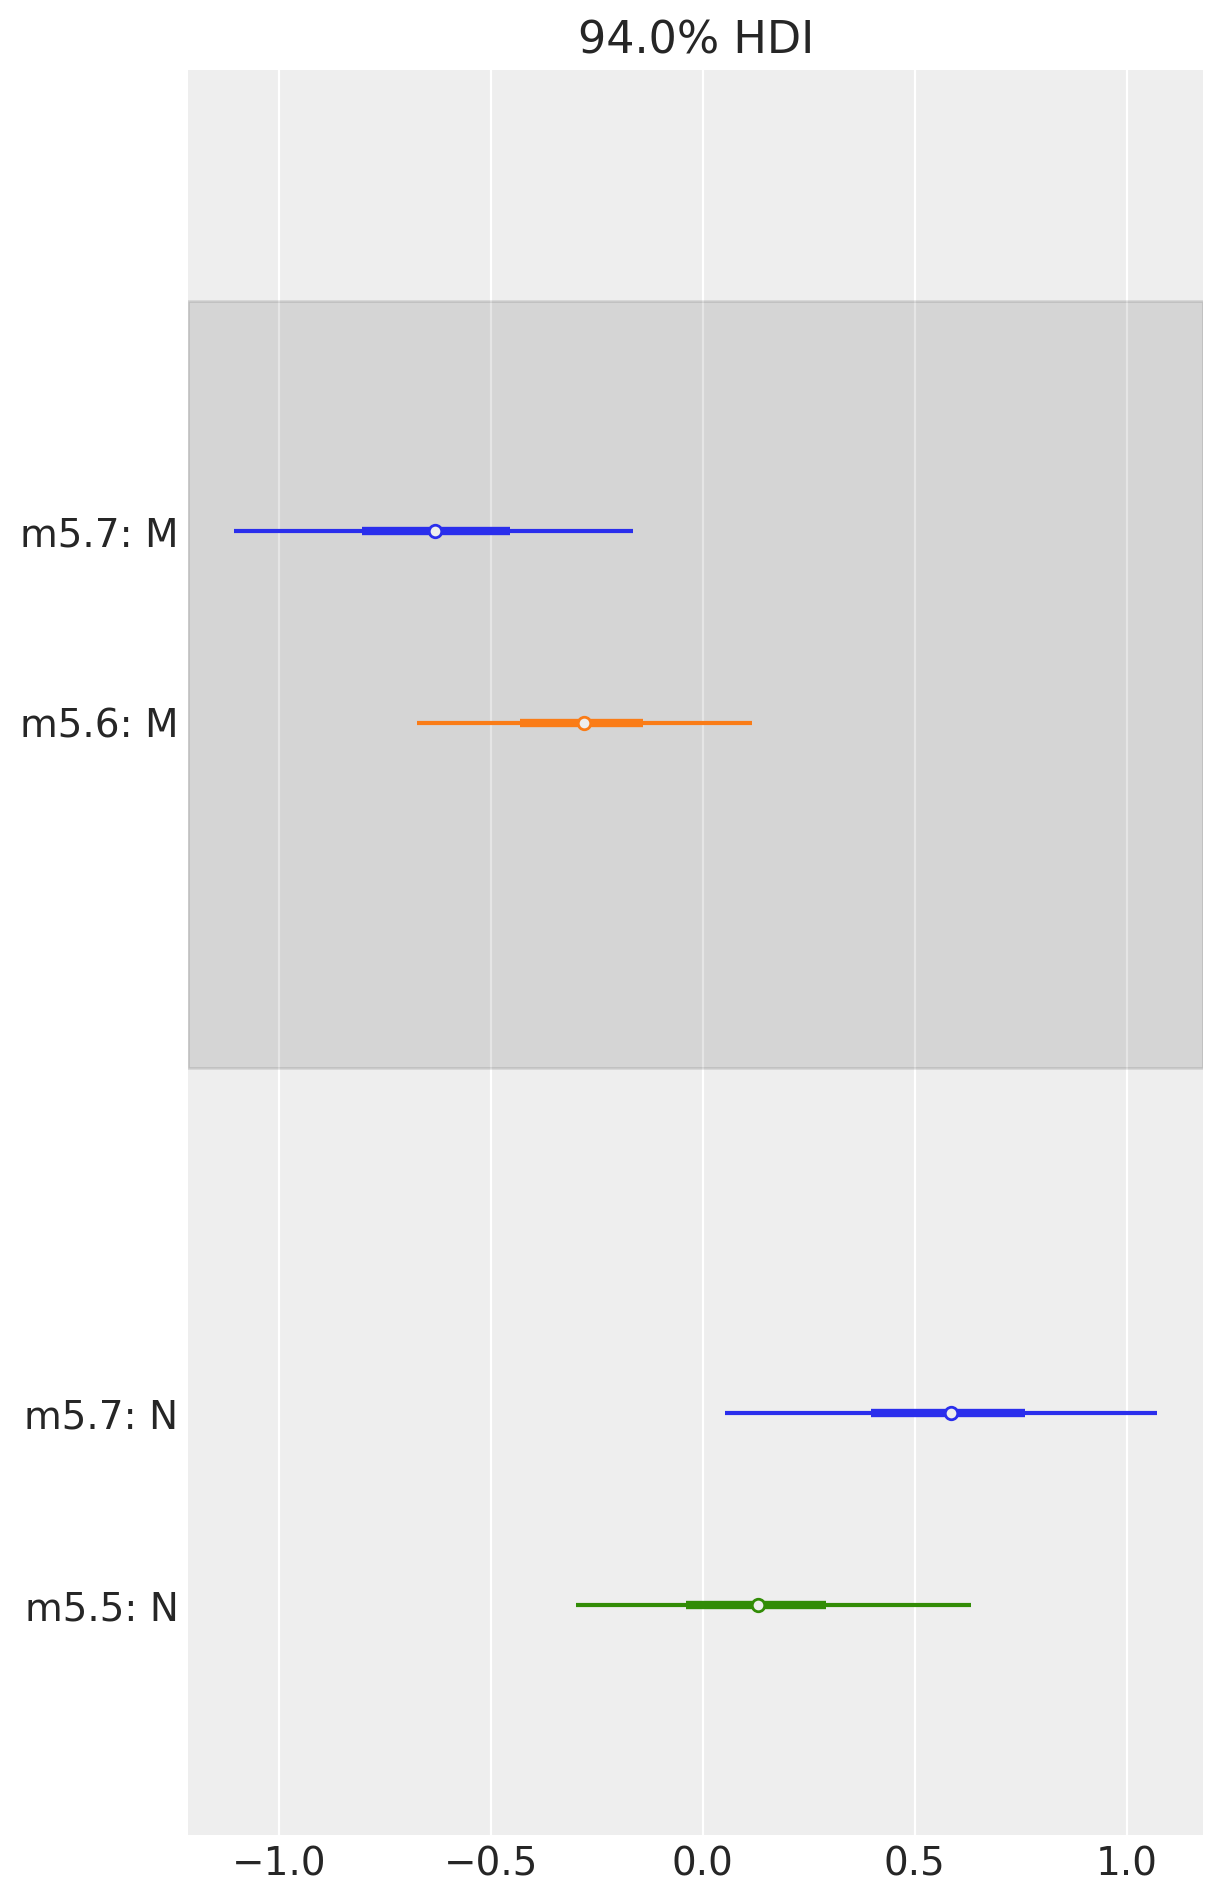

In [47]:
az.plot_forest(
    [results_5_7, results_5_6, results_5_5],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["M", "N"],
    combined=True,
);

#### Code 5.41


In [48]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
N = 0 # N is fixed at 0

a = results_5_7.posterior["Intercept"].values.flatten()
bN = results_5_7.posterior["N"].values.flatten()
bM = results_5_7.posterior["M"].values.flatten()
mu_pred = np.zeros((len(xseq), len(a)))

for (i, x) in enumerate(xseq):
    mu_pred[i] = a + bN * N + bM * x

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

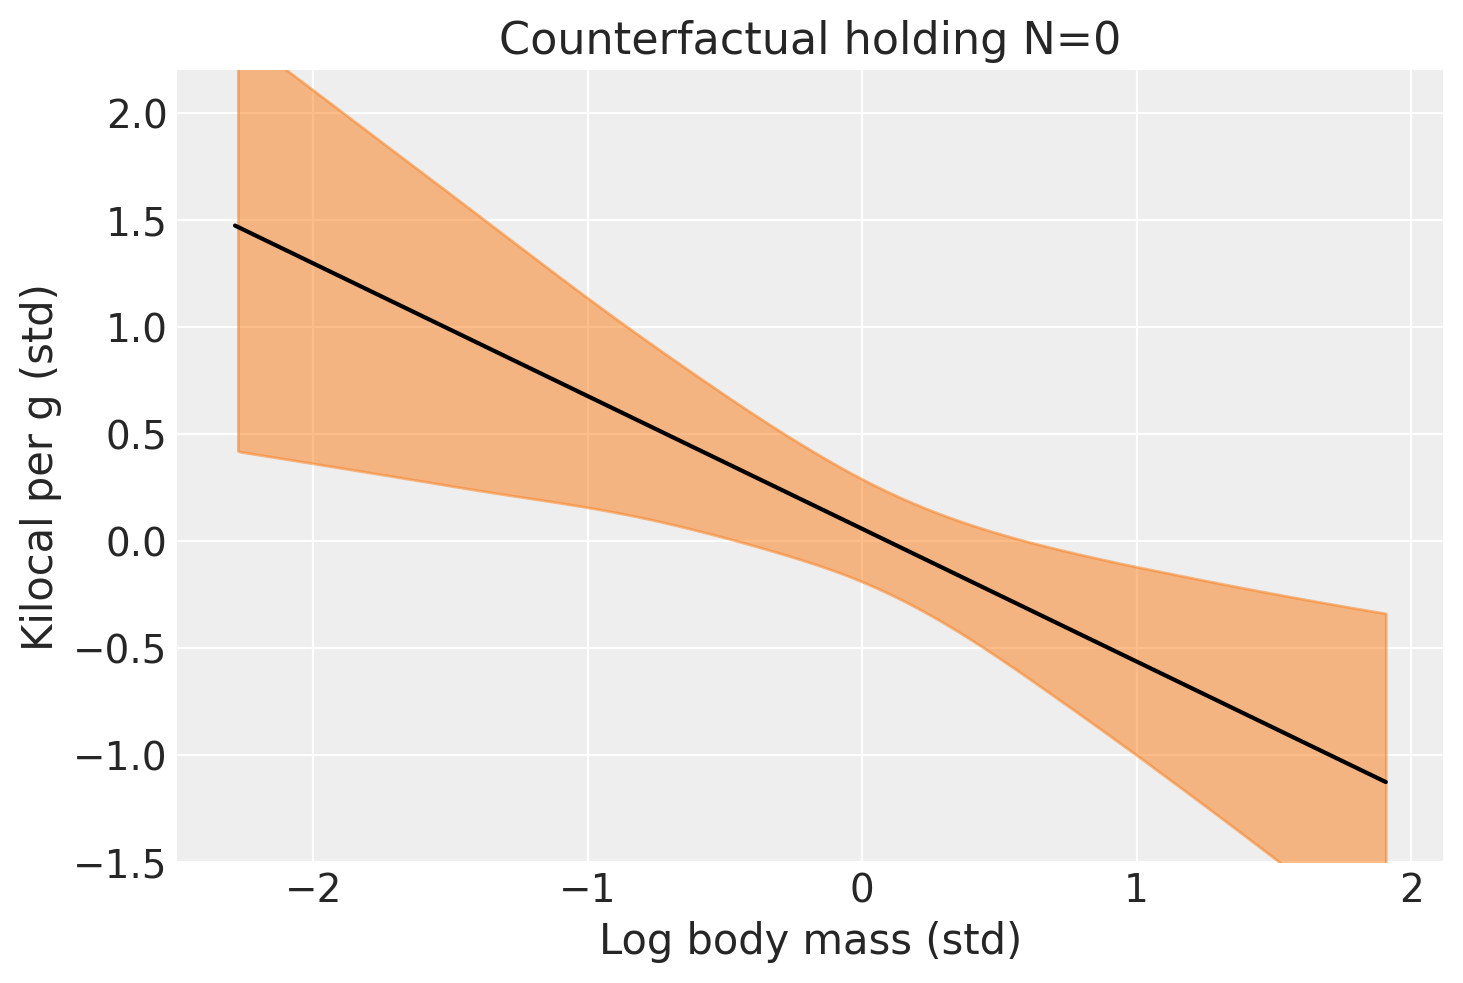

In [49]:
plt.plot(xseq, mu_mean, c="black")
az.plot_hdi(xseq, hdi_data=mu_PI)

plt.ylim(-1.5, 2.2)

plt.title("Counterfactual holding N=0")
plt.ylabel("Kilocal per g (std)")
plt.xlabel("Log body mass (std)");

#### Code 5.42


In [50]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

#### Code 5.43


In [51]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

#### Code 5.44

Not included yet. Don't know how to replicate that list of DAGs here in Python.

#### Code 5.45

In [52]:
d = pd.read_csv("data/Howell1.csv")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### Code 5.46

In [53]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,178.172,20.023,142.727,218.912
mu_male,178.781,22.331,136.877,219.411


#### Code 5.47

In [54]:
d["sex"] = np.where(d["male"] == 1, 2, 1)
d["sex"]

0      2
1      1
2      1
3      2
4      1
      ..
539    2
540    2
541    1
542    2
543    2
Name: sex, Length: 544, dtype: int64

#### Code 5.48

All the following ways are valid to tell Bambi that one of the predictors is categoric

* The type of the column is object.
* The type of the column is categoric.
* The variable name is wrapped within `C()`
* Using the passin the variable name to the `categorical` argument in `Model()`.

In [55]:
priors = {
    "sex": bmb.Prior("Normal", mu=178, sd=20),
    "sigma": bmb.Prior("Uniform", lower=0, upper=50)
}

# The 0 is to omit the intercept
model_5_8 = bmb.Model("height ~ 0 + sex", d, priors=priors, categorical="sex")
results_5_8 = model_5_8.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, sex]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


There's a bug here in the labelling, it should show \[1\] and \[2\], and not the dimension number.

In [56]:
az.summary(results_5_8, kind="stats")

,mean,sd,hdi_3%,hdi_97%
sex[0],134.961,1.649,131.980,138.135
sex[1],142.627,1.782,139.387,146.017
height_sigma,27.430,0.867,25.849,29.117


#### Code 5.49

Not sure how to do it... Can we manipulate the data in `results_5_8.posterior`?

#### Code 5.50

In [57]:
d = pd.read_csv("data/milk.csv")
list(d["clade"].unique())

['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape']

#### Code 5.51

We could do this step, but it is not necessary since Bambi can automatically handle categoric variables.

#### Code 5.52

Since `"clade"` is of type object, we don't need to tell Bambi it is a categorical variable, since it will be treated as such by default.

In [58]:
d["K"] = standardize(d["kcal.per.g"])

priors = {
    "clade": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# The 0 is to omit the intercept
model_5_9 = bmb.Model("K ~ 0 + clade", d, priors=priors)
results_5_9 = model_5_9.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, clade]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


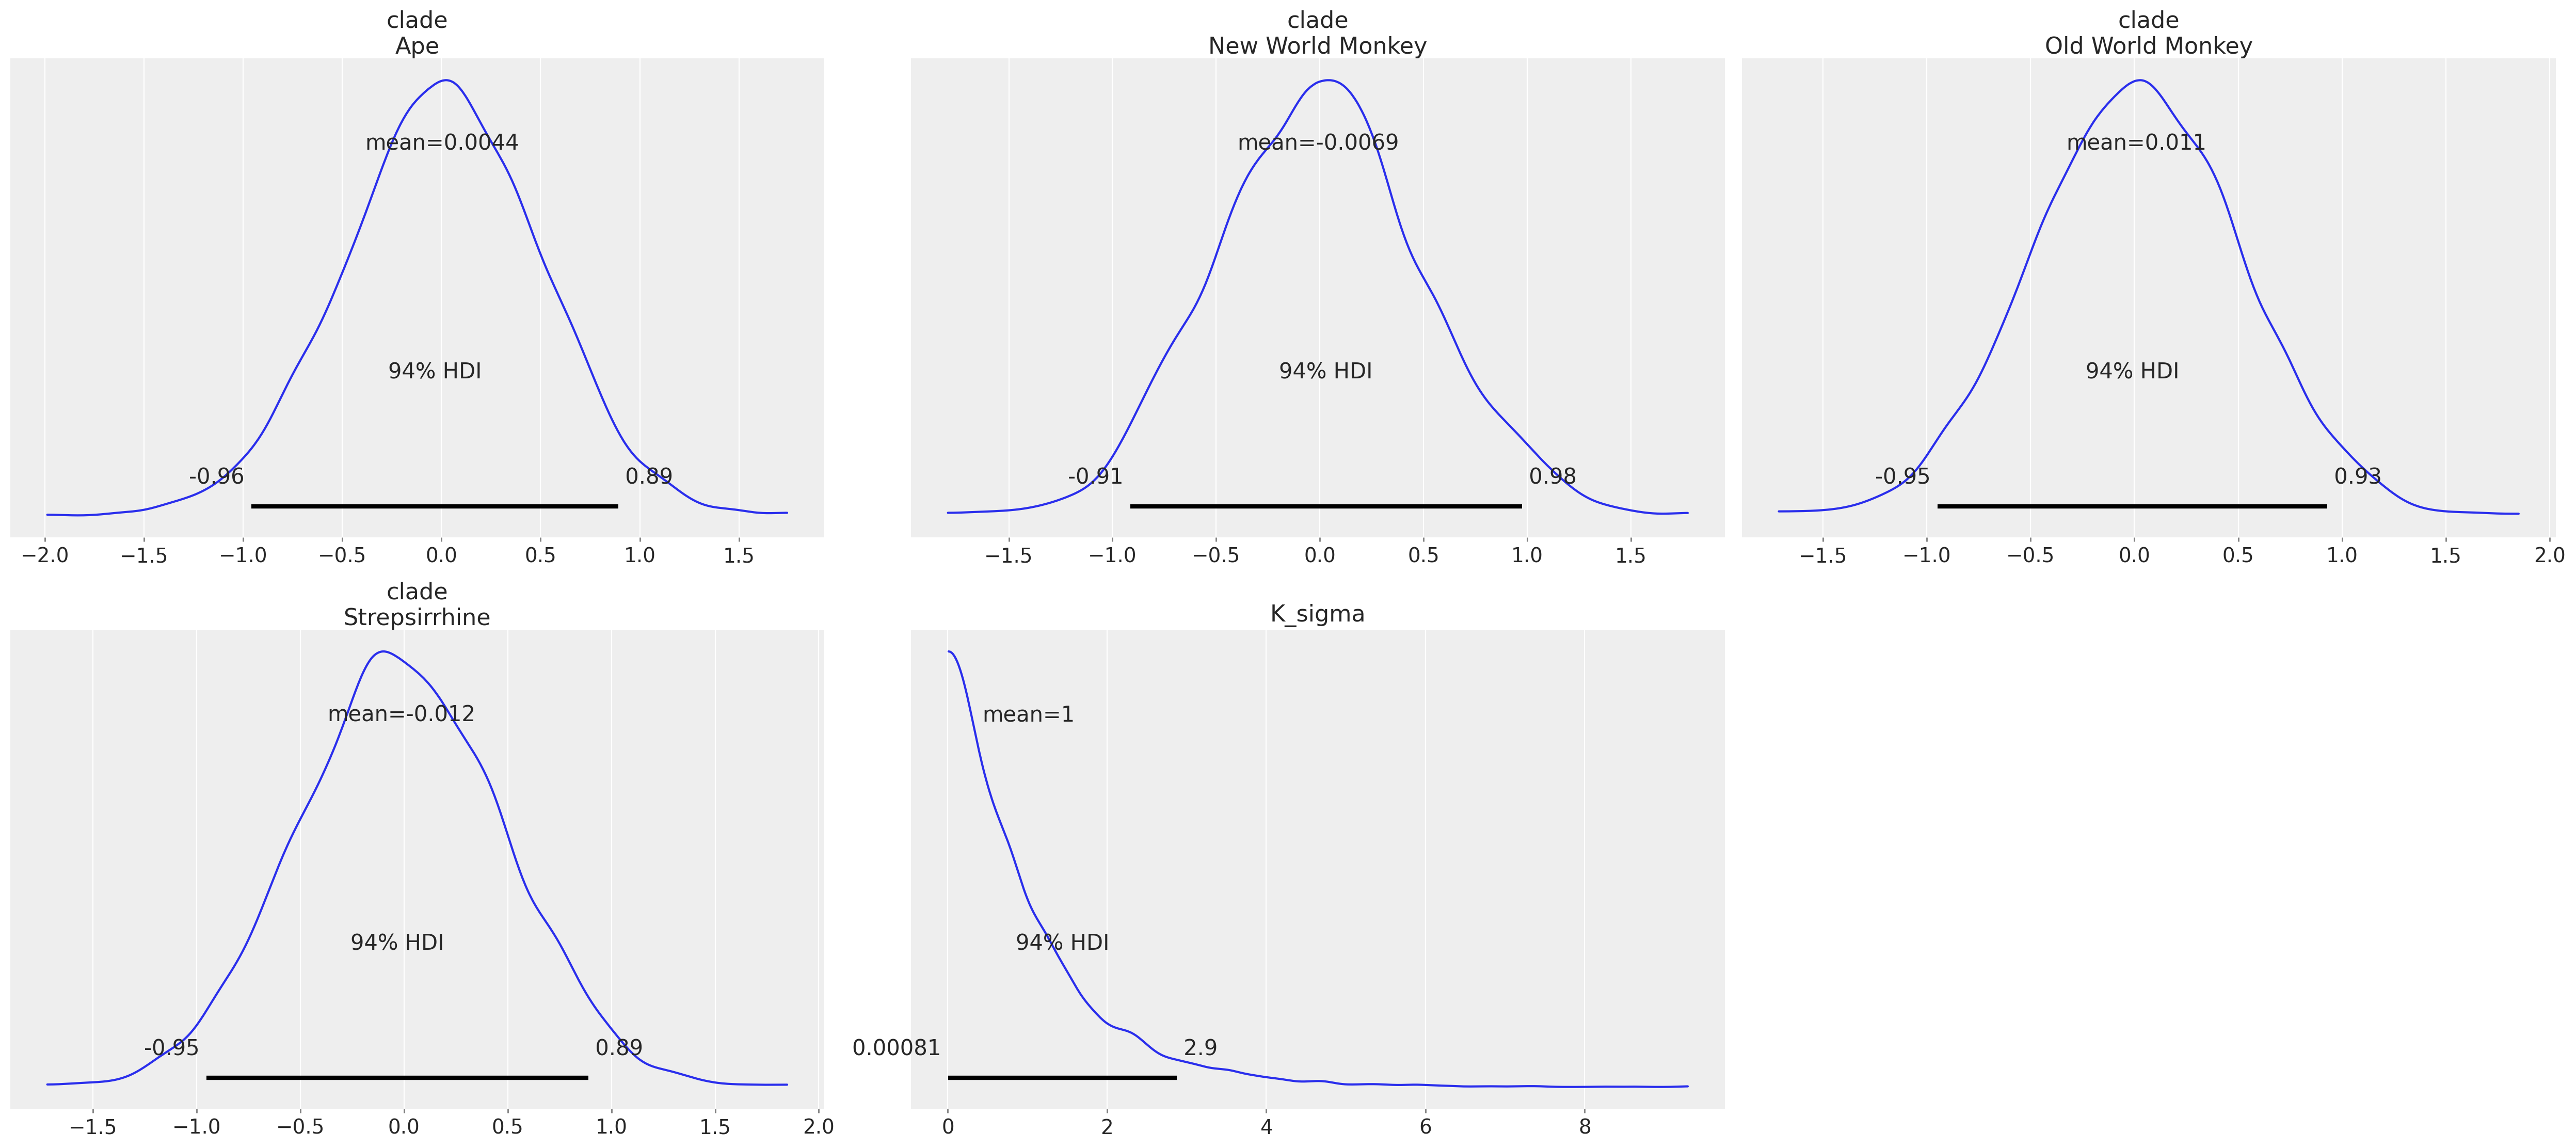

In [59]:
model_5_9.plot_priors();

We could use `az.plot_trace()`, but it is not easy to see to which clade they represent.

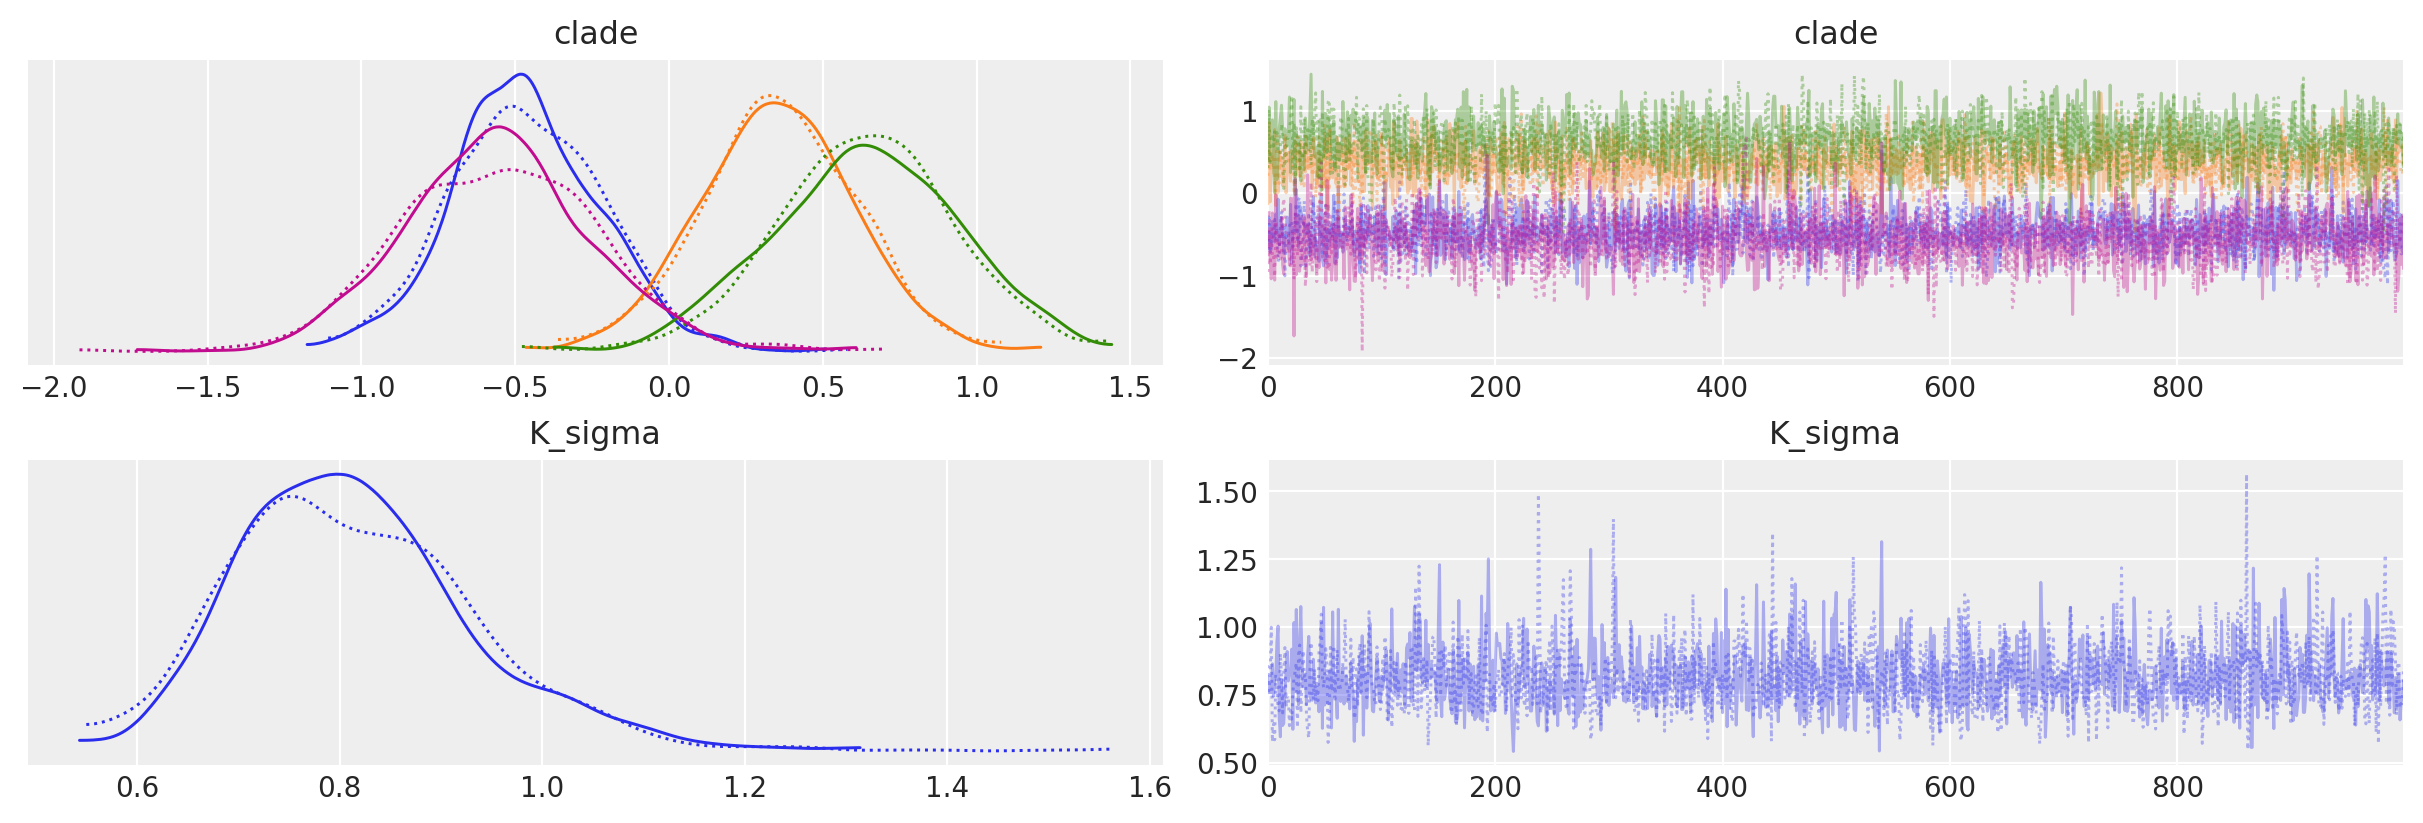

In [60]:
az.plot_trace(results_5_9);

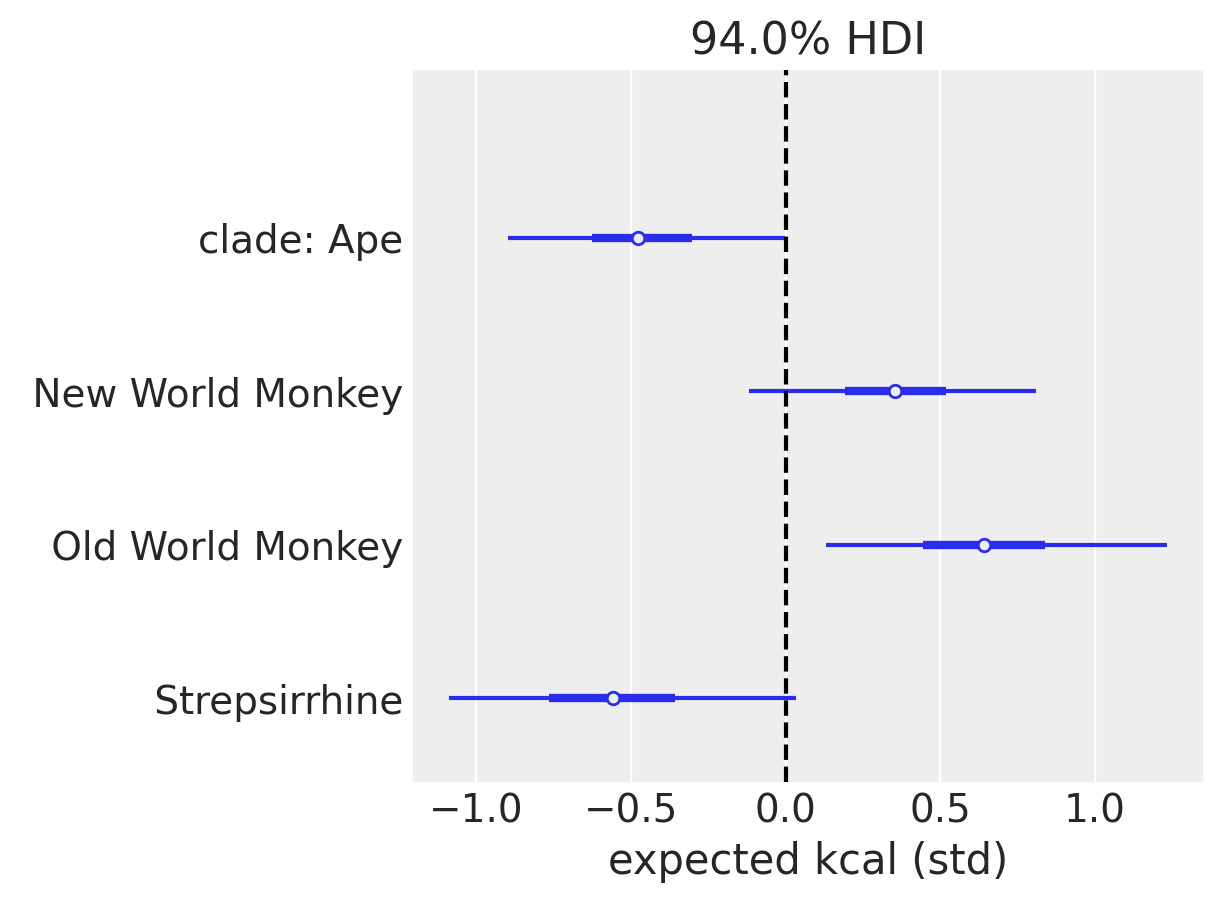

In [61]:
az.plot_forest(results_5_9, combined=True, var_names = "clade")
plt.axvline(0, c="k", ls="--")
plt.xlabel("expected kcal (std)");

#### Code 5.53

In [62]:
d["house"] = np.random.choice(
    ["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"] * 8,
    size=d.shape[0], 
    replace=False
)

#### Code 5.54

In [63]:
priors = {
    "clade": bmb.Prior("Normal", mu=0, sd=0.5),
    "house": bmb.Prior("Normal", mu=0, sd=0.5),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# The 0 is to omit the intercept
model_5_10 = bmb.Model("K ~ 0 + clade + house", d, priors=priors)
results_5_10 = model_5_10.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [K_sigma, house, clade]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


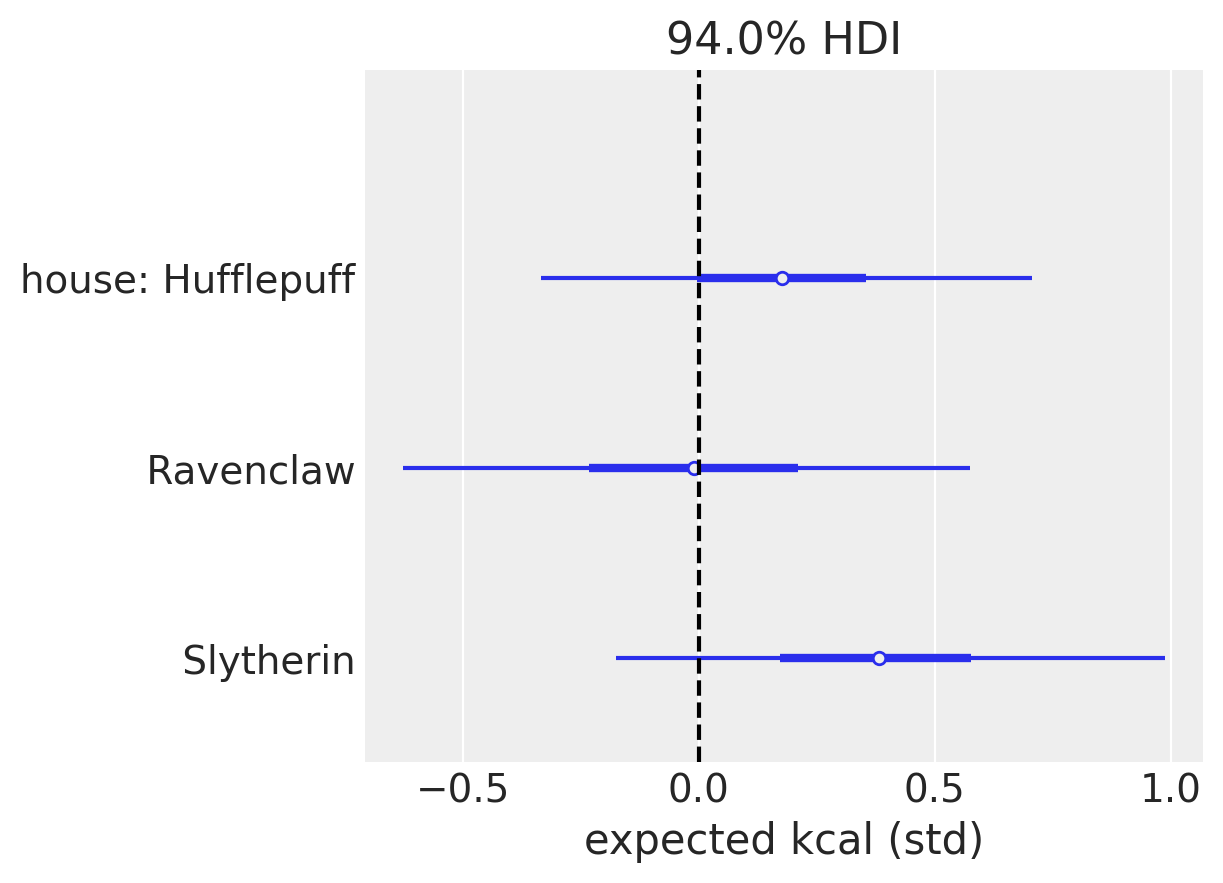

In [64]:
az.plot_forest(results_5_10, combined=True, var_names = "house")
plt.axvline(0, c="k", ls="--")
plt.xlabel("expected kcal (std)");

Why don't you see Gryffindor? Because the dummy encoding Bambi uses for `"house"`. If we don't use dummy encoding for this second categorical variable, the sum of the columns corresponding to `"clade"` would be equal to the sum of the columns corresponding to `"house"`, and that means the design matrix would not be of full rank. The first categorical variable uses one-hot encoding because there is not intercept. If we had an intercept here, both categorical variables would have been represented with levels - 1 dummy variables.

In [65]:
%watermark -n -u -v -iv -w

Last updated: Wed Apr 21 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

pandas    : 1.2.4
numpy     : 1.20.2
matplotlib: 3.4.1
daft      : 0.1.2
scipy     : 1.6.2
bambi     : 0.4.1
arviz     : 0.11.2

Watermark: 2.2.0

